Loaded 2940 days of data from 2017-08-30 to 2025-09-16
Training on 2352 days, Testing on 588 days
Step 1000: Avg Reward = 18.17, Avg Portfolio = 59959.08, Time: 0.0m
Step 2000: Avg Reward = 1.07, Avg Portfolio = 43006.24, Time: 0.0m
Step 3000: Avg Reward = -18.90, Avg Portfolio = 6805.68, Time: 0.1m
Step 4000: Avg Reward = 38.85, Avg Portfolio = 7824.07, Time: 0.1m
Step 5000: Avg Reward = -8.61, Avg Portfolio = 15457.40, Time: 0.2m
Step 6000: Avg Reward = -31.42, Avg Portfolio = 36608.53, Time: 0.2m
Step 7000: Avg Reward = -77.60, Avg Portfolio = 20849.31, Time: 0.3m
Step 8000: Avg Reward = 42.07, Avg Portfolio = 4959.54, Time: 0.3m
Step 9000: Avg Reward = 8.25, Avg Portfolio = 2576.61, Time: 0.3m
Step 10000: Avg Reward = 5.08, Avg Portfolio = 3792.50, Time: 0.4m
Step 11000: Avg Reward = -160.84, Avg Portfolio = 26297.10, Time: 0.4m
Episode 5: Avg Reward = -10.69, Final Portfolio = 19903.06
Step 12000: Avg Reward = -0.61, Avg Portfolio = 28296.43, Time: 0.4m
Step 13000: Avg Reward = -4

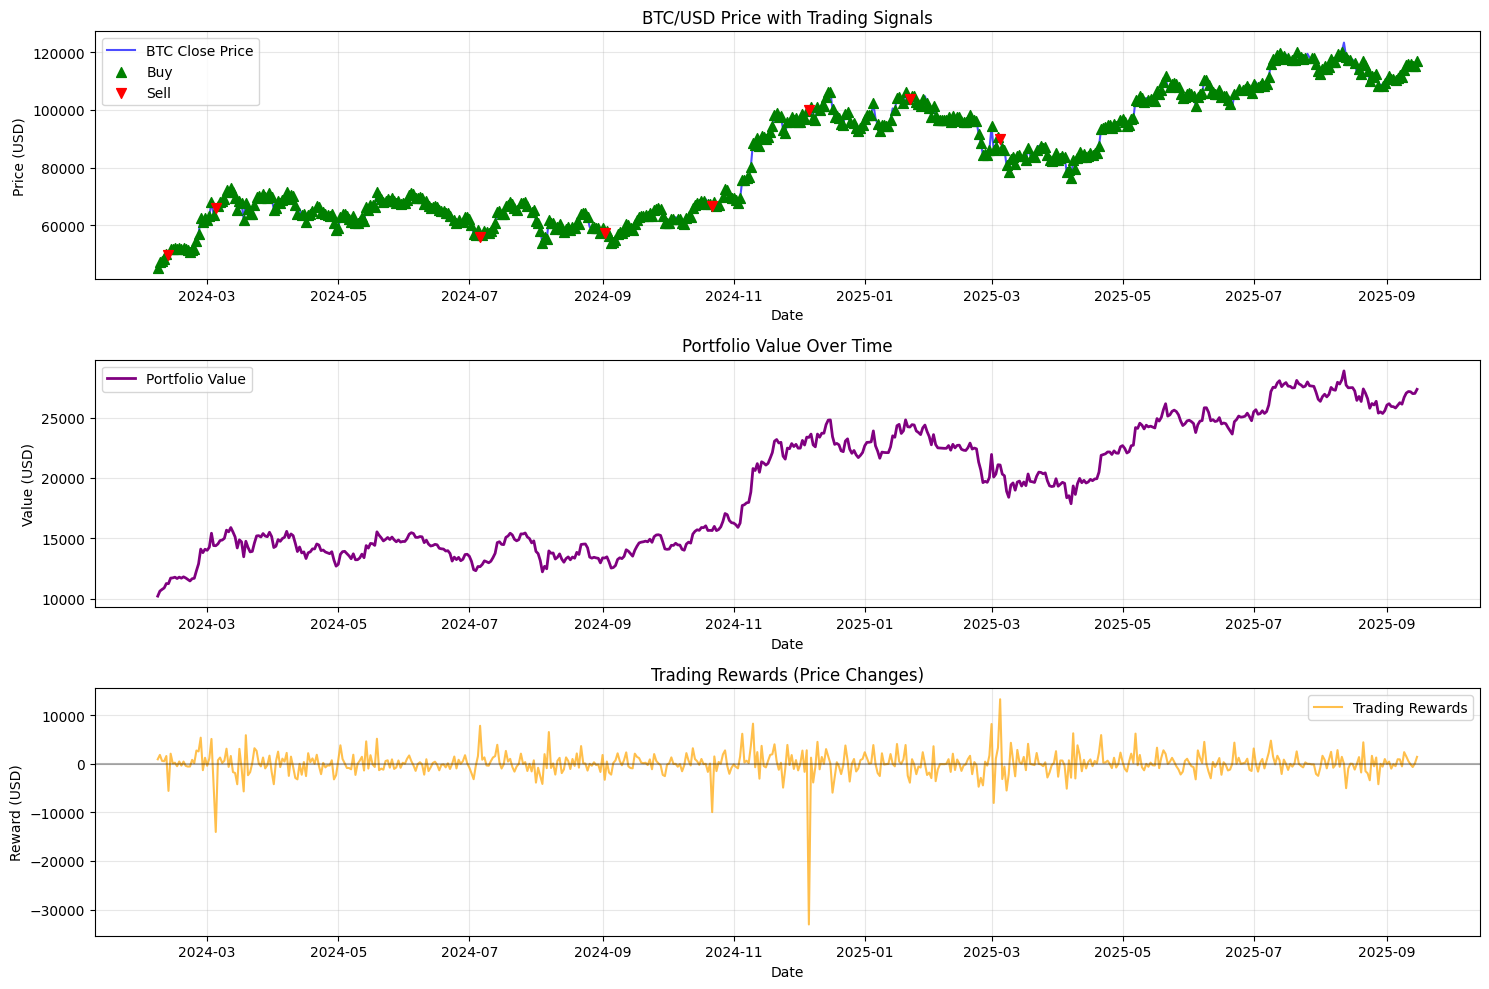

In [3]:
import pandas as pd
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import ccxt
from datetime import datetime
import time

# Function to compute RSI
def compute_rsi(data, periods=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
    rs = gain / loss
    rs = rs.replace([np.inf, -np.inf], np.nan)
    return 100 - (100 / (1 + rs))

# Function to compute MACD
def compute_macd(data, slow=26, fast=12, signal=9):
    exp1 = data.ewm(span=fast, adjust=False).mean()
    exp2 = data.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd

# Step 1: Load and Preprocess Data
def load_and_preprocess_data(file_path='BTC-USD-Binance-daily.csv'):
    # Load CSV data
    df = pd.read_csv(file_path, parse_dates=['OpenTime'], index_col='OpenTime')
    df = df.sort_index()
    
    # Add technical indicators
    df['SMA_10'] = df['Close'].rolling(window=10).mean()
    df['RSI'] = compute_rsi(df['Close'], periods=14)
    df['MACD'] = compute_macd(df['Close'])
    
    # Drop rows with NaN values
    df = df.dropna()
    
    # Ensure required columns
    required_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI', 'MACD']
    if not all(col in df for col in required_cols):
        raise ValueError(f"Data must contain {required_cols}")
    
    print(f"Loaded {len(df)} days of data from {df.index[0].date()} to {df.index[-1].date()}")
    return df

# Step 2: Custom Single-Row Trading Environment
class SingleRowTradingEnv(gym.Env):
    def __init__(self, df, initial_cash=10000):
        super(SingleRowTradingEnv, self).__init__()
        
        self.df = df.reset_index()  # Reset index for easier stepping
        self.initial_cash = initial_cash
        self.trade_fee = 0.001  # 0.1% transaction fee
        
        # Action space: 0=hold, 1=buy, 2=sell
        self.action_space = spaces.Discrete(3)
        
        # State space: OHLCV + SMA_10 + RSI + MACD (8 features)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, shape=(8,), dtype=np.float32
        )
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.cash = self.initial_cash
        self.btc_held = 0
        self.position = 0  # 0=neutral, 1=long, -1=short
        self.last_price = 0
        
        # Get initial state
        state = self._get_state()
        return state, {}
    
    def _get_state(self):
        """Get current row as state"""
        if self.current_step >= len(self.df):
            # Pad with last valid state if at end
            return self.last_state
        
        row = self.df.iloc[self.current_step]
        state = np.array([
            row['Open'], row['High'], row['Low'], row['Close'], row['Volume'],
            row['SMA_10'], row['RSI'], row['MACD']
        ], dtype=np.float32)
        
        self.last_state = state
        return state
    
    def step(self, action):
        if self.current_step >= len(self.df) - 1:
            # End of episode
            return self._get_state(), 0, True, False, {
                'total_value': self.cash + self.btc_held * self.df.iloc[-1]['Close']
            }
        
        current_price = self.df.iloc[self.current_step]['Close']
        next_price = self.df.iloc[self.current_step + 1]['Close']
        price_change = next_price - current_price
        
        # Calculate reward based on action and price movement
        reward = 0
        if action == 1:  # Buy
            if self.position != 1:  # Not already long
                # Calculate how much BTC we can buy
                btc_to_buy = self.cash / current_price
                fee = btc_to_buy * current_price * self.trade_fee
                self.cash -= (btc_to_buy * current_price + fee)
                self.btc_held = btc_to_buy
                self.position = 1
                self.last_price = current_price
                
                # Reward: price change (profit if price goes up)
                reward = price_change
            else:
                # Already holding, reward based on price change
                reward = price_change
        
        elif action == 2:  # Sell
            if self.position == 1 and self.btc_held > 0:  # Has position to sell
                # Sell all BTC
                cash_from_sell = self.btc_held * current_price
                fee = cash_from_sell * self.trade_fee
                self.cash += cash_from_sell - fee
                self.btc_held = 0
                self.position = 0
                
                # Reward: inverse price change (profit if price goes down from last buy)
                reward = self.last_price - current_price
            else:
                # No position to sell, small penalty
                reward = -abs(price_change) * 0.1
        
        else:  # Hold (action == 0)
            # No position change, no reward
            reward = 0
        
        self.current_step += 1
        
        # Check if done
        done = self.current_step >= len(self.df) - 1
        truncated = False
        
        # Info dictionary
        info = {
            'total_value': self.cash + self.btc_held * next_price,
            'cash': self.cash,
            'btc_held': self.btc_held,
            'price': next_price,
            'action': action
        }
        
        # Get next state
        next_state = self._get_state()
        
        return next_state, reward, done, truncated, info

# Step 3: Training Progress Callback
class TrainingProgressCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingProgressCallback, self).__init__(verbose)
        self.episode = 0
        self.episode_rewards = []
        self.episode_values = []
        self.start_time = time.time()

    def _on_step(self) -> bool:
        # Collect reward and portfolio value
        reward = self.locals['rewards'][0]
        info = self.locals['infos'][0]
        portfolio_value = info['total_value']
        
        self.episode_rewards.append(reward)
        self.episode_values.append(portfolio_value)
        
        # Print progress every 1000 steps
        if self.n_calls % 1000 == 0:
            avg_reward = np.mean(self.episode_rewards[-100:]) if len(self.episode_rewards) >= 100 else 0
            avg_value = np.mean(self.episode_values[-100:]) if len(self.episode_values) >= 100 else 0
            elapsed = time.time() - self.start_time
            print(f"Step {self.n_calls}: Avg Reward = {avg_reward:.2f}, Avg Portfolio = {avg_value:.2f}, Time: {elapsed/60:.1f}m")
        
        # Check if episode is done
        if self.locals['dones'][0]:
            self.episode += 1
            if self.episode % 5 == 0:  # Print every 5 episodes
                avg_reward = np.mean(self.episode_rewards) if self.episode_rewards else 0
                avg_value = np.mean(self.episode_values) if self.episode_values else 0
                print(f"Episode {self.episode}: Avg Reward = {avg_reward:.2f}, Final Portfolio = {avg_value:.2f}")
                self.episode_rewards = []
                self.episode_values = []
        
        return True

# Step 4: Train the Model
def train_model(df, total_timesteps=100000):
    # Split data: 80% train, 20% test
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size].copy()
    test_df = df.iloc[train_size:].copy()
    
    print(f"Training on {len(train_df)} days, Testing on {len(test_df)} days")
    
    # Create training environment
    train_env = DummyVecEnv([lambda: SingleRowTradingEnv(train_df)])
    
    # Initialize PPO model
    model = PPO('MlpPolicy', train_env, verbose=0, learning_rate=0.0003, n_steps=2048)
    
    # Train with progress tracking
    callback = TrainingProgressCallback()
    model.learn(total_timesteps=total_timesteps, callback=callback)
    model.save('ppo_single_row_btc_model')
    
    print("Training completed. Model saved as 'ppo_single_row_btc_model'")
    return model, train_df, test_df

# Step 5: Evaluate Model with Action Accuracy
def evaluate_model(model, test_df):
    env = SingleRowTradingEnv(test_df)
    obs, _ = env.reset()
    
    actions = []
    rewards = []
    portfolio_values = []
    prices = []
    timestamps = []
    
    done = False
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        
        actions.append(action)
        rewards.append(reward)
        portfolio_values.append(info['total_value'])
        prices.append(info['price'])
        timestamps.append(test_df.index[env.current_step - 1] if env.current_step > 0 else test_df.index[0])
    
    # Calculate action accuracy
    correct_actions = 0
    total_actions = len(actions)
    
    for i, (action, reward) in enumerate(zip(actions, rewards)):
        if i >= len(test_df) - 1:
            break
            
        current_price = test_df.iloc[i]['Close']
        next_price = test_df.iloc[i + 1]['Close']
        price_change = next_price - current_price
        
        # Heuristic: Buy if price increases, Sell if decreases, Hold if stable
        threshold = 0.005  # 0.5%
        
        if action == 1 and price_change > 0:  # Buy when price goes up
            correct_actions += 1
        elif action == 2 and price_change < 0:  # Sell when price goes down
            correct_actions += 1
        elif action == 0 and abs(price_change) <= threshold:  # Hold when stable
            correct_actions += 1
    
    accuracy = (correct_actions / total_actions) * 100 if total_actions > 0 else 0
    print(f"Action Accuracy: {accuracy:.2f}% ({correct_actions}/{total_actions} correct)")
    
    return timestamps, portfolio_values, actions, prices, rewards

# Step 6: Visualize Results
def plot_results(timestamps, portfolio_values, actions, prices, test_df):
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Price with Buy/Sell signals
    plt.subplot(3, 1, 1)
    plt.plot(timestamps, prices, label='BTC Close Price', color='blue', alpha=0.7)
    
    buy_indices = [i for i, a in enumerate(actions) if a == 1]
    sell_indices = [i for i, a in enumerate(actions) if a == 2]
    
    if buy_indices:
        plt.scatter([timestamps[i] for i in buy_indices], 
                   [prices[i] for i in buy_indices], 
                   marker='^', color='green', s=50, label='Buy', zorder=5)
    
    if sell_indices:
        plt.scatter([timestamps[i] for i in sell_indices], 
                   [prices[i] for i in sell_indices], 
                   marker='v', color='red', s=50, label='Sell', zorder=5)
    
    plt.title('BTC/USD Price with Trading Signals')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Portfolio Value
    plt.subplot(3, 1, 2)
    plt.plot(timestamps, portfolio_values, label='Portfolio Value', color='purple', linewidth=2)
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Value (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Rewards
    plt.subplot(3, 1, 3)
    plt.plot(timestamps, rewards, label='Trading Rewards', color='orange', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Trading Rewards (Price Changes)')
    plt.xlabel('Date')
    plt.ylabel('Reward (USD)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('single_row_btc_results.png', dpi=300, bbox_inches='tight')
    plt.show()

# Step 7: Real-Time Prediction Function
def realtime_prediction(model, historical_df, exchange, window_size=50):
    print("Starting real-time single-row prediction...")
    
    cash = 10000
    btc_held = 0
    position = 0
    last_price = 0
    
    while True:
        try:
            # Fetch latest data (last 100 days for indicators)
            ohlcv = exchange.fetch_ohlcv('BTC/USDT', '1d', limit=100)
            live_df = pd.DataFrame(ohlcv, columns=['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])
            live_df['OpenTime'] = pd.to_datetime(live_df['timestamp'], unit='ms')
            live_df.set_index('OpenTime', inplace=True)
            live_df.drop('timestamp', axis=1, inplace=True)
            
            # Preprocess with indicators
            live_df['SMA_10'] = live_df['Close'].rolling(window=10).mean()
            live_df['RSI'] = compute_rsi(live_df['Close'], periods=14)
            live_df['MACD'] = compute_macd(live_df['Close'])
            live_df = live_df.dropna()
            
            if len(live_df) == 0:
                print("Waiting for sufficient data...")
                time.sleep(300)  # Wait 5 minutes
                continue
            
            # Get latest row as state
            latest_row = live_df.iloc[-1]
            state = np.array([
                latest_row['Open'], latest_row['High'], latest_row['Low'], 
                latest_row['Close'], latest_row['Volume'],
                latest_row['SMA_10'], latest_row['RSI'], latest_row['MACD']
            ], dtype=np.float32)
            
            # Predict action
            action, _ = model.predict(state.reshape(1, -1))
            action = int(action[0])
            current_price = latest_row['Close']
            
            # Execute action
            if action == 1 and position != 1:  # Buy
                if cash >= current_price:
                    btc_to_buy = cash / current_price
                    fee = btc_to_buy * current_price * 0.001
                    cash -= (btc_to_buy * current_price + fee)
                    btc_held = btc_to_buy
                    position = 1
                    last_price = current_price
                    print(f"{datetime.now()}: BUY {btc_to_buy:.6f} BTC @ ${current_price:.2f} | Cash: ${cash:.2f}")
            
            elif action == 2 and position == 1:  # Sell
                if btc_held > 0:
                    cash_from_sell = btc_held * current_price
                    fee = cash_from_sell * 0.001
                    cash += cash_from_sell - fee
                    btc_held = 0
                    position = 0
                    print(f"{datetime.now()}: SELL {btc_held:.6f} BTC @ ${current_price:.2f} | Cash: ${cash:.2f}")
            
            else:  # Hold
                print(f"{datetime.now()}: HOLD | Cash: ${cash:.2f} | BTC: {btc_held:.6f} | Price: ${current_price:.2f}")
            
            # Calculate portfolio value
            portfolio_value = cash + btc_held * current_price
            print(f"Portfolio Value: ${portfolio_value:.2f}")
            
            # Wait for next prediction (e.g., every 5 minutes for testing)
            time.sleep(300)  # 5 minutes
            
        except Exception as e:
            print(f"Error: {e}")
            time.sleep(60)

# Main Execution
if __name__ == '__main__':
    # Load and preprocess data
    df = load_and_preprocess_data('BTC-USD-Binance-daily.csv')
    
    # Train the model
    model, train_df, test_df = train_model(df, total_timesteps=100000)
    
    # Evaluate on test data
    timestamps, portfolio_values, actions, prices, rewards = evaluate_model(model, test_df)
    
    # Calculate performance metrics
    total_return = (portfolio_values[-1] / portfolio_values[0] - 1) * 100
    avg_reward = np.mean(rewards)
    print(f"\n=== PERFORMANCE METRICS ===")
    print(f"Total Return: {total_return:.2f}%")
    print(f"Average Reward per Trade: ${avg_reward:.2f}")
    print(f"Final Portfolio Value: ${portfolio_values[-1]:.2f}")
    
    # Plot results
    plot_results(timestamps, portfolio_values, actions, prices, test_df)
    
    # Optional: Run real-time prediction
    # exchange = ccxt.binance({'enableRateLimit': True})
    # realtime_prediction(model, df, exchange)

In [ ]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import logger as sb3logger
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from datetime import datetime
import warnings

# -----------------------------
# Silence / verbosity control
# -----------------------------
VERBOSE = False  # Set False to suppress prints/logs
warnings.filterwarnings("ignore")
# Silence stable-baselines3 logger
sb3logger.set_level(sb3logger.logging.CRITICAL)

# -----------------------------
# Utilities: Indicators
# -----------------------------

def compute_rsi(series: pd.Series, periods: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=periods, min_periods=periods).mean()
    loss = (-delta).clip(lower=0).rolling(window=periods, min_periods=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(method='bfill')


def compute_macd(series: pd.Series, slow: int = 26, fast: int = 12, signal: int = 9) -> pd.Series:
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return hist.fillna(method='bfill')


def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['SMA_10'] = df['Close'].rolling(window=10, min_periods=1).mean()
    df['RSI_14'] = compute_rsi(df['Close'], periods=14)
    df['MACD_HIST'] = compute_macd(df['Close'])
    df = df.dropna().reset_index(drop=False)
    return df

# -----------------------------
# Environment
# -----------------------------
class SingleRowTradingEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, df: pd.DataFrame, scaler: StandardScaler = None, initial_cash: float = 10000.0,
                 trade_fee: float = 0.001, slippage: float = 0.0005, max_position_fraction: float = 1.0):
        super().__init__()
        self.raw_df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.trade_fee = trade_fee
        self.slippage = slippage
        self.max_position_fraction = float(max_position_fraction)

        self.feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14', 'MACD_HIST']
        for col in self.feature_cols:
            if col not in self.raw_df.columns:
                raise ValueError(f"Missing required column in df: {col}")

        self.scaler = scaler
        self.action_space = spaces.Discrete(3)
        obs_dim = len(self.feature_cols) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.cash = float(self.initial_cash)
        self.position = 0.0
        self.position_value = 0.0
        self.last_portfolio_value = float(self.initial_cash)
        self.total_fees = 0.0
        self.trades = 0
        self.returns = []
        return self._get_observation(), {}

    def _get_observation(self):
        row = self.raw_df.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32).reshape(1, -1)
        if self.scaler is not None:
            features = self.scaler.transform(features)
        features = features.flatten()

        denom = (self.cash + self.position * row['Close']) if (self.cash + self.position * row['Close']) > 0 else 1.0
        cash_ratio = np.array([self.cash / denom])
        position_fraction = np.array([ (self.position * row['Close']) / denom ])

        obs = np.concatenate([features, cash_ratio, position_fraction]).astype(np.float32)
        return obs

    def step(self, action):
        done = False
        row = self.raw_df.iloc[self.current_step]
        price = float(row['Close'])
        pre_portfolio = self.cash + self.position * price

        if action == 1:
            target_invest = self.max_position_fraction * pre_portfolio
            available_cash = self.cash
            invest_amount = min(available_cash, target_invest)
            if invest_amount > 0:
                slippage_cost = invest_amount * self.slippage
                fee = invest_amount * self.trade_fee
                effective_amount = invest_amount - fee - slippage_cost
                btc_bought = effective_amount / price
                self.position += btc_bought
                self.cash -= invest_amount
                self.total_fees += fee + slippage_cost
                self.trades += 1

        elif action == 2:
            if self.position > 0:
                gross = self.position * price
                slippage_cost = gross * self.slippage
                fee = gross * self.trade_fee
                cash_received = gross - fee - slippage_cost
                self.cash += cash_received
                self.total_fees += fee + slippage_cost
                self.position = 0.0
                self.trades += 1

        self.current_step += 1
        if self.current_step >= len(self.raw_df):
            done = True
            self.current_step = len(self.raw_df) - 1

        next_price = float(self.raw_df.iloc[self.current_step]['Close'])
        post_portfolio = self.cash + self.position * next_price
        reward = post_portfolio - pre_portfolio
        self.returns.append(reward)
        self.last_portfolio_value = post_portfolio

        info = {
            'total_value': post_portfolio,
            'cash': self.cash,
            'position': self.position,
            'price': next_price,
            'trades': self.trades,
            'total_fees': self.total_fees
        }

        obs = self._get_observation()
        truncated = False
        return obs, float(reward), done, truncated, info

    def render(self, mode='human'):
        if VERBOSE:
            price = float(self.raw_df.iloc[self.current_step]['Close'])
            print(f"Step {self.current_step} | Price: {price:.2f} | Cash: {self.cash:.2f} | Position: {self.position:.6f} | Portfolio: {self.last_portfolio_value:.2f}")

# -----------------------------
# Callback for logging
# -----------------------------
class TrainingProgressCallback(BaseCallback):
    def __init__(self, verbose=0, print_freq=1000):
        super().__init__(verbose)
        self.print_freq = print_freq
        self.episode = 0

    def _on_step(self) -> bool:
        # Keep callback but don't print unless VERBOSE
        if VERBOSE and (self.n_calls % self.print_freq == 0):
            try:
                rewards = self.locals.get('rewards', None)
                infos = self.locals.get('infos', None)
                if rewards is not None and infos is not None and len(rewards) > 0:
                    avg_reward = np.mean(rewards[-100:]) if len(rewards) >= 1 else 0
                    avg_value = np.mean([inf.get('total_value', 0) for inf in infos[-1:]])
                    print(f"Step {self.n_calls}: Avg Recent Reward {avg_reward:.4f}, Example Info Portfolio {avg_value:.2f}")
            except Exception:
                pass
        return True

# -----------------------------
# Training and evaluation helpers
# -----------------------------

def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, parse_dates=['OpenTime'], index_col='OpenTime')
    df = df.sort_index()
    df = add_indicators(df)
    df = df.set_index('OpenTime')
    if VERBOSE:
        print(f"Loaded {len(df)} days of data from {df.index[0].date()} to {df.index[-1].date()}")
    return df


def build_scaler(train_df: pd.DataFrame, feature_cols: list):
    scaler = StandardScaler()
    scaler.fit(train_df[feature_cols].values)
    return scaler


def train_model(df: pd.DataFrame, total_timesteps: int = 100000, initial_cash: float = 10000.0):
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size].copy()
    test_df = df.iloc[train_size:].copy()

    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14', 'MACD_HIST']
    scaler = build_scaler(train_df, feature_cols)

    if VERBOSE:
        print(f"Train days: {len(train_df)}, Test days: {len(test_df)}")

    env = DummyVecEnv([lambda: SingleRowTradingEnv(train_df.reset_index(), scaler=scaler, initial_cash=initial_cash)])

    # Ensure PPO is quiet
    model = PPO('MlpPolicy', env, verbose=0, learning_rate=3e-4, n_steps=2048)

    callback = TrainingProgressCallback(print_freq=2000)
    model.learn(total_timesteps=total_timesteps, callback=callback)
    model.save('ppo_single_row_btc_improved')
    if VERBOSE:
        print("Model saved: ppo_single_row_btc_improved.zip")
    return model, scaler, train_df, test_df


def evaluate_model(model: PPO, scaler: StandardScaler, test_df: pd.DataFrame, initial_cash: float = 10000.0):
    env = SingleRowTradingEnv(test_df.reset_index(), scaler=scaler, initial_cash=initial_cash)
    obs, _ = env.reset()

    actions = []
    rewards = []
    portfolio_values = []
    prices = []
    timestamps = []

    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        action = int(action[0]) if isinstance(action, (list, np.ndarray)) else int(action)
        obs, reward, done, truncated, info = env.step(action)

        actions.append(action)
        rewards.append(reward)
        portfolio_values.append(info['total_value'])
        prices.append(info['price'])
        timestamps.append(test_df.index[env.current_step])

    pf = np.array(portfolio_values)
    returns = np.diff(pf) / (pf[:-1] + 1e-9)
    total_return = (pf[-1] / pf[0] - 1) * 100 if len(pf) > 1 else 0
    avg_reward = np.mean(rewards) if len(rewards) > 0 else 0

    days = len(test_df)
    years = days / 252.0
    cagr = ((pf[-1] / pf[0]) ** (1 / years) - 1) * 100 if years > 0 and len(pf) > 1 else 0

    if len(returns) > 1:
        sharpe = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(252)
    else:
        sharpe = 0.0

    roll_max = np.maximum.accumulate(pf)
    drawdowns = (pf - roll_max) / (roll_max + 1e-9)
    max_dd = drawdowns.min() * 100

    if VERBOSE:
        print(f"Total Return: {total_return:.2f}% | CAGR: {cagr:.2f}% | Sharpe: {sharpe:.2f} | MaxDD: {max_dd:.2f}%")

    return timestamps, portfolio_values, actions, prices, rewards, {'total_return': total_return, 'cagr': cagr, 'sharpe': sharpe, 'max_dd': max_dd}


def plot_results(timestamps, portfolio_values, actions, prices, rewards, savepath='results_improved.png'):
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(timestamps, prices, label='Close Price')
    buy_idx = [i for i, a in enumerate(actions) if a == 1]
    sell_idx = [i for i, a in enumerate(actions) if a == 2]
    if buy_idx:
        plt.scatter([timestamps[i] for i in buy_idx], [prices[i] for i in buy_idx], marker='^', s=50, label='Buy')
    if sell_idx:
        plt.scatter([timestamps[i] for i in sell_idx], [prices[i] for i in sell_idx], marker='v', s=50, label='Sell')
    plt.legend(); plt.title('Price & Actions')

    plt.subplot(3, 1, 2)
    plt.plot(timestamps, portfolio_values, label='Portfolio Value')
    plt.legend(); plt.title('Portfolio Value')

    plt.subplot(3, 1, 3)
    plt.plot(timestamps, rewards, label='Rewards')
    plt.axhline(0, color='k', linewidth=0.5)
    plt.legend(); plt.title('Rewards')

    plt.tight_layout(); plt.savefig(savepath, dpi=300)
    # Only show plot when verbose is True
    if VERBOSE:
        plt.show()

# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    df = load_and_preprocess_data('BTC-USD-Binance-daily.csv')
    model, scaler, train_df, test_df = train_model(df, total_timesteps=50000, initial_cash=10000.0)
    timestamps, portfolio_values, actions, prices, rewards, metrics = evaluate_model(model, scaler, test_df)
    # Print metrics only if VERBOSE
    if VERBOSE:
        print(metrics)
    plot_results(timestamps, portfolio_values, actions, prices, rewards)
    ########### not working qcuratly which i want it should be 


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


AttributeError: module 'stable_baselines3.common.logger' has no attribute 'set_level'

In [ ]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import logger as sb3logger
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import time
from datetime import datetime
import warnings

# -----------------------------
# Silence / verbosity control
# -----------------------------
VERBOSE = False  # Set False to suppress prints/logs
warnings.filterwarnings("ignore")
# Silence stable-baselines3 logger
sb3logger.set_level(sb3logger.logging.CRITICAL)

# -----------------------------
# Utilities: Indicators
# -----------------------------

def compute_rsi(series: pd.Series, periods: int = 14) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0).rolling(window=periods, min_periods=periods).mean()
    loss = (-delta).clip(lower=0).rolling(window=periods, min_periods=periods).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi.fillna(method='bfill')


def compute_macd(series: pd.Series, slow: int = 26, fast: int = 12, signal: int = 9) -> pd.Series:
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return hist.fillna(method='bfill')


def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['SMA_10'] = df['Close'].rolling(window=10, min_periods=1).mean()
    df['RSI_14'] = compute_rsi(df['Close'], periods=14)
    df['MACD_HIST'] = compute_macd(df['Close'])
    df = df.dropna().reset_index(drop=False)
    return df

# -----------------------------
# Environment
# -----------------------------
class SingleRowTradingEnv(gym.Env):
    metadata = {"render.modes": ["human"]}

    def __init__(self, df: pd.DataFrame, scaler: StandardScaler = None, initial_cash: float = 10000.0,
                 trade_fee: float = 0.001, slippage: float = 0.0005, max_position_fraction: float = 1.0):
        super().__init__()
        self.raw_df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.trade_fee = trade_fee
        self.slippage = slippage
        self.max_position_fraction = float(max_position_fraction)

        self.feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14', 'MACD_HIST']
        for col in self.feature_cols:
            if col not in self.raw_df.columns:
                raise ValueError(f"Missing required column in df: {col}")

        self.scaler = scaler
        self.action_space = spaces.Discrete(3)
        obs_dim = len(self.feature_cols) + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = 0
        self.cash = float(self.initial_cash)
        self.position = 0.0
        self.position_value = 0.0
        self.last_portfolio_value = float(self.initial_cash)
        self.total_fees = 0.0
        self.trades = 0
        self.returns = []
        return self._get_observation(), {}

    def _get_observation(self):
        row = self.raw_df.iloc[self.current_step]
        features = row[self.feature_cols].values.astype(np.float32).reshape(1, -1)
        if self.scaler is not None:
            features = self.scaler.transform(features)
        features = features.flatten()

        denom = (self.cash + self.position * row['Close']) if (self.cash + self.position * row['Close']) > 0 else 1.0
        cash_ratio = np.array([self.cash / denom])
        position_fraction = np.array([ (self.position * row['Close']) / denom ])

        obs = np.concatenate([features, cash_ratio, position_fraction]).astype(np.float32)
        return obs

    def step(self, action):
        done = False
        row = self.raw_df.iloc[self.current_step]
        price = float(row['Close'])
        pre_portfolio = self.cash + self.position * price

        if action == 1:
            target_invest = self.max_position_fraction * pre_portfolio
            available_cash = self.cash
            invest_amount = min(available_cash, target_invest)
            if invest_amount > 0:
                slippage_cost = invest_amount * self.slippage
                fee = invest_amount * self.trade_fee
                effective_amount = invest_amount - fee - slippage_cost
                btc_bought = effective_amount / price
                self.position += btc_bought
                self.cash -= invest_amount
                self.total_fees += fee + slippage_cost
                self.trades += 1

        elif action == 2:
            if self.position > 0:
                gross = self.position * price
                slippage_cost = gross * self.slippage
                fee = gross * self.trade_fee
                cash_received = gross - fee - slippage_cost
                self.cash += cash_received
                self.total_fees += fee + slippage_cost
                self.position = 0.0
                self.trades += 1

        self.current_step += 1
        if self.current_step >= len(self.raw_df):
            done = True
            self.current_step = len(self.raw_df) - 1

        next_price = float(self.raw_df.iloc[self.current_step]['Close'])
        post_portfolio = self.cash + self.position * next_price
        reward = post_portfolio - pre_portfolio
        self.returns.append(reward)
        self.last_portfolio_value = post_portfolio

        info = {
            'total_value': post_portfolio,
            'cash': self.cash,
            'position': self.position,
            'price': next_price,
            'trades': self.trades,
            'total_fees': self.total_fees
        }

        obs = self._get_observation()
        truncated = False
        return obs, float(reward), done, truncated, info

    def render(self, mode='human'):
        if VERBOSE:
            price = float(self.raw_df.iloc[self.current_step]['Close'])
            print(f"Step {self.current_step} | Price: {price:.2f} | Cash: {self.cash:.2f} | Position: {self.position:.6f} | Portfolio: {self.last_portfolio_value:.2f}")

# -----------------------------
# Callback for logging
# -----------------------------
class TrainingProgressCallback(BaseCallback):
    def __init__(self, verbose=0, print_freq=1000):
        super().__init__(verbose)
        self.print_freq = print_freq
        self.episode = 0

    def _on_step(self) -> bool:
        # Keep callback but don't print unless VERBOSE
        if VERBOSE and (self.n_calls % self.print_freq == 0):
            try:
                rewards = self.locals.get('rewards', None)
                infos = self.locals.get('infos', None)
                if rewards is not None and infos is not None and len(rewards) > 0:
                    avg_reward = np.mean(rewards[-100:]) if len(rewards) >= 1 else 0
                    avg_value = np.mean([inf.get('total_value', 0) for inf in infos[-1:]])
                    print(f"Step {self.n_calls}: Avg Recent Reward {avg_reward:.4f}, Example Info Portfolio {avg_value:.2f}")
            except Exception:
                pass
        return True

# -----------------------------
# Training and evaluation helpers
# -----------------------------

def load_and_preprocess_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path, parse_dates=['OpenTime'], index_col='OpenTime')
    df = df.sort_index()
    df = add_indicators(df)
    df = df.set_index('OpenTime')
    if VERBOSE:
        print(f"Loaded {len(df)} days of data from {df.index[0].date()} to {df.index[-1].date()}")
    return df


def build_scaler(train_df: pd.DataFrame, feature_cols: list):
    scaler = StandardScaler()
    scaler.fit(train_df[feature_cols].values)
    return scaler


def train_model(df: pd.DataFrame, total_timesteps: int = 100000, initial_cash: float = 10000.0):
    train_size = int(len(df) * 0.8)
    train_df = df.iloc[:train_size].copy()
    test_df = df.iloc[train_size:].copy()

    feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10', 'RSI_14', 'MACD_HIST']
    scaler = build_scaler(train_df, feature_cols)

    if VERBOSE:
        print(f"Train days: {len(train_df)}, Test days: {len(test_df)}")

    env = DummyVecEnv([lambda: SingleRowTradingEnv(train_df.reset_index(), scaler=scaler, initial_cash=initial_cash)])

    # Ensure PPO is quiet
    model = PPO('MlpPolicy', env, verbose=0, learning_rate=3e-4, n_steps=2048)

    callback = TrainingProgressCallback(print_freq=2000)
    model.learn(total_timesteps=total_timesteps, callback=callback)
    model.save('ppo_single_row_btc_improved')
    if VERBOSE:
        print("Model saved: ppo_single_row_btc_improved.zip")
    return model, scaler, train_df, test_df


def evaluate_model(model: PPO, scaler: StandardScaler, test_df: pd.DataFrame, initial_cash: float = 10000.0):
    env = SingleRowTradingEnv(test_df.reset_index(), scaler=scaler, initial_cash=initial_cash)
    obs, _ = env.reset()

    actions = []
    rewards = []
    portfolio_values = []
    prices = []
    timestamps = []

    done = False
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        action = int(action[0]) if isinstance(action, (list, np.ndarray)) else int(action)
        obs, reward, done, truncated, info = env.step(action)

        actions.append(action)
        rewards.append(reward)
        portfolio_values.append(info['total_value'])
        prices.append(info['price'])
        timestamps.append(test_df.index[env.current_step])

    pf = np.array(portfolio_values)
    returns = np.diff(pf) / (pf[:-1] + 1e-9)
    total_return = (pf[-1] / pf[0] - 1) * 100 if len(pf) > 1 else 0
    avg_reward = np.mean(rewards) if len(rewards) > 0 else 0

    days = len(test_df)
    years = days / 252.0
    cagr = ((pf[-1] / pf[0]) ** (1 / years) - 1) * 100 if years > 0 and len(pf) > 1 else 0

    if len(returns) > 1:
        sharpe = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(252)
    else:
        sharpe = 0.0

    roll_max = np.maximum.accumulate(pf)
    drawdowns = (pf - roll_max) / (roll_max + 1e-9)
    max_dd = drawdowns.min() * 100

    if VERBOSE:
        print(f"Total Return: {total_return:.2f}% | CAGR: {cagr:.2f}% | Sharpe: {sharpe:.2f} | MaxDD: {max_dd:.2f}%")

    return timestamps, portfolio_values, actions, prices, rewards, {'total_return': total_return, 'cagr': cagr, 'sharpe': sharpe, 'max_dd': max_dd}


def plot_results(timestamps, portfolio_values, actions, prices, rewards, savepath='results_improved.png'):
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(timestamps, prices, label='Close Price')
    buy_idx = [i for i, a in enumerate(actions) if a == 1]
    sell_idx = [i for i, a in enumerate(actions) if a == 2]
    if buy_idx:
        plt.scatter([timestamps[i] for i in buy_idx], [prices[i] for i in buy_idx], marker='^', s=50, label='Buy')
    if sell_idx:
        plt.scatter([timestamps[i] for i in sell_idx], [prices[i] for i in sell_idx], marker='v', s=50, label='Sell')
    plt.legend(); plt.title('Price & Actions')

    plt.subplot(3, 1, 2)
    plt.plot(timestamps, portfolio_values, label='Portfolio Value')
    plt.legend(); plt.title('Portfolio Value')

    plt.subplot(3, 1, 3)
    plt.plot(timestamps, rewards, label='Rewards')
    plt.axhline(0, color='k', linewidth=0.5)
    plt.legend(); plt.title('Rewards')

    plt.tight_layout(); plt.savefig(savepath, dpi=300)
    # Only show plot when verbose is True
    if VERBOSE:
        plt.show()

# -----------------------------
# Main
# -----------------------------
if __name__ == '__main__':
    df = load_and_preprocess_data('BTC-USD-Binance-daily.csv')
    model, scaler, train_df, test_df = train_model(df, total_timesteps=50000, initial_cash=10000.0)
    timestamps, portfolio_values, actions, prices, rewards, metrics = evaluate_model(model, scaler, test_df)
    # Print metrics only if VERBOSE
    if VERBOSE:
        print(metrics)
    plot_results(timestamps, portfolio_values, actions, prices, rewards)
    ########### not working qcuratly which i want it should be 
